In [3]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 10 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1

In [37]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  8 14:06:40 2023

@author: chaitrag
"""
from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

ENV_NAME_2= "CartPole-v1"
input_dim =4
#ENV_NAME_3 = "MountainCar-v0"
#input_dim=2

env = gym.make(ENV_NAME_2)#, render_mode="human")

# Define hyperparameters
gamma = 0.95 #discount
epsilon = 1.0 #explore rate
epsilon_min = 0.001
epsilon_decay = .9
learning_rate = 0.0001
batch_size = 10
memory_size = 100000000
episode_length = 2000
target_update_frequency = 2  # Update the target network every N episodes

# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)
        #self.fc4 = nn.Linear(10, 10)
        #self.fc5 = nn.Linear(10, output_dim)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        #x = torch.relu(self.fc4(x))
        #x = torch.relu(self.fc5(x))
        return x

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [38]:
# Create both the main and target networks
input_dim = input_dim
output_dim = env.action_space.n
main_network = QNetwork(input_dim, output_dim)
target_network = QNetwork(input_dim, output_dim)
target_network.load_state_dict(main_network.state_dict())  # Initialize target network with main network's weights
optimizer = optim.Adam(main_network.parameters(), lr=learning_rate)

# Initialize replay memory
replay_memory = []

# Function to choose an action
def choose_action(state):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        q_values = main_network(torch.Tensor(state))
        return torch.argmax(q_values).item()
def get_Q_network_output(state):
    return main_network(torch.Tensor(state))

In [39]:
# Main training loop
num_episodes = 100
for episode in range(num_episodes):
    state = env.reset()
    #img = plt.imshow(env.render('rgb_array')) # only call this once
    total_reward = 0

    for t in range(episode_length):
        #img.set_data(env.render('rgb_array')) # just update the data
        #display.display(plt.gcf())
        #display.clear_output(wait=True)
        action = choose_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        replay_memory.append((state, action, reward, next_state, done))#store experiences into replay memory
        state = next_state

        if done:
            #print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")
            break

        if len(replay_memory) >= batch_size:
            batch = random.sample(replay_memory, batch_size)

            for state_batch, action_batch, reward_batch, next_state_batch, done_batch in batch:
                state_batch = torch.Tensor(state_batch)
                next_state_batch = torch.Tensor(next_state_batch)

                q_values = main_network(state_batch)
                target = q_values.clone().detach()

                if not done_batch:
                    target[action_batch] = reward_batch + gamma * torch.max(target_network(next_state_batch))
                else:
                    target[action_batch] = reward_batch

                loss = nn.MSELoss()(q_values, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")
    # Decay exploration rate
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Update the target network
    if episode % target_update_frequency == 0:
        target_network.load_state_dict(main_network.state_dict())

Episode: 1, Total Reward: 22.0, Epsilon: 1.0
Episode: 2, Total Reward: 18.0, Epsilon: 0.9
Episode: 3, Total Reward: 16.0, Epsilon: 0.81
Episode: 4, Total Reward: 17.0, Epsilon: 0.7290000000000001
Episode: 5, Total Reward: 13.0, Epsilon: 0.6561000000000001
Episode: 6, Total Reward: 17.0, Epsilon: 0.5904900000000002
Episode: 7, Total Reward: 15.0, Epsilon: 0.5314410000000002
Episode: 8, Total Reward: 15.0, Epsilon: 0.47829690000000014
Episode: 9, Total Reward: 27.0, Epsilon: 0.43046721000000016
Episode: 10, Total Reward: 25.0, Epsilon: 0.38742048900000015
Episode: 11, Total Reward: 25.0, Epsilon: 0.34867844010000015
Episode: 12, Total Reward: 17.0, Epsilon: 0.31381059609000017
Episode: 13, Total Reward: 22.0, Epsilon: 0.28242953648100017
Episode: 14, Total Reward: 98.0, Epsilon: 0.25418658283290013
Episode: 15, Total Reward: 14.0, Epsilon: 0.22876792454961012
Episode: 16, Total Reward: 12.0, Epsilon: 0.2058911320946491
Episode: 17, Total Reward: 13.0, Epsilon: 0.1853020188851842
Episode:

average reward:267.0 
Good job: Total reward exceeded threshold of 500


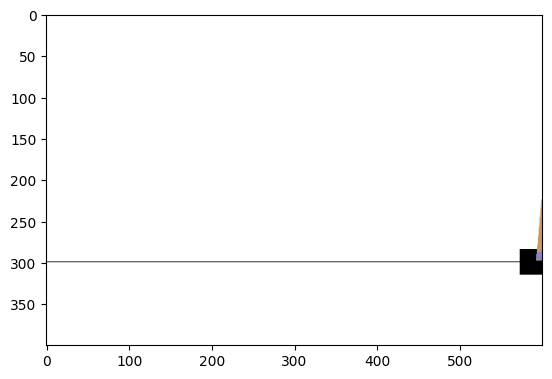

In [41]:
# Test
#epsilon = 50
TEST_EPISODES = 2
total_reward = 0
img = plt.imshow(env.render('rgb_array')) # only call this once
for test_episode in range(TEST_EPISODES):
    state = env.reset()
    while True:
        img.set_data(env.render('rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = choose_action(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        if done:
            #print(f"Episode: {test_episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")
            break
average_reward = total_reward / TEST_EPISODES
print(f"average reward:{average_reward} ")
if average_reward > 200:
    print ("Good job: Total reward exceeded threshold of 500")
else:
    print ("You can do better: Total reward did not exceed threshold of 500")
#Threshold for reward for cart_pole_v1 500
env.close()